In [1]:
import os
import sys
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'src'))

from pathlib import Path
from tqdm import tqdm
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
from utils import *
import time

import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

/home/khoa-ys/Projects/venv_for_projects/bio_ml_venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using cuda device


In [2]:
root_path = os.path.dirname(os.getcwd())
data_path = os.path.join(root_path, "dwt_shortened_dataset")
image_dict = json.load(open(os.path.join(data_path, 'image_dict.json'), 'r'))
print(*image_dict.keys(), sep=', ')

Astrocitoma, Carcinoma, Ependimoma, Glioblastoma, Meningioma, Neurocitoma, Oligodendroglioma, Papiloma, Schwannoma, _NORMAL


### Load feature map

#### Embed the feature map

In [3]:
# Embed the data by PCA and TSNE if haven't
embed = False
if embed:
    data = pd.read_csv(os.path.join(data_path, 'image_value_dict.csv'))
    X, labels = data.iloc[:, :-1].to_numpy(), data.iloc[:, -1].to_numpy()
    X, labels
    
    # By PCA
    pca = PCA(n_components=64)
    y = pd.factorize(labels)[0]
    pca_X = pca.fit_transform(X)

    data = pd.DataFrame(pca_X)
    data['label'] = labels
    data.to_csv(os.path.join(data_path, "pca_image_value_dict.csv"), index=False)

    plt.figure()
    plt.title('Embedding of feature map on first and second principle components')
    plt.scatter(pca_X[:, 0], pca_X[:, 1], c=y)

    # By TSNE
    tsne = TSNE(n_components=64, method='exact', learning_rate='auto', init='random', perplexity=3)
    tsne_X = tsne.fit_transform(X)

    data = pd.DataFrame(tsne_X)
    data['label'] = labels
    data.to_csv(os.path.join(data_path, "tsne_image_value_dict.csv"), index=False)
    
# Else load the saved data by guven method:
embed_method = 'tsne' # or 'pca'
data = pd.read_csv(os.path.join(data_path, embed_method+'_image_value_dict.csv'))
X, labels = data.iloc[:, :-1].to_numpy(), data.iloc[:, -1].to_numpy()
y = pd.factorize(labels)[0]
print(X.shape)
X, labels

(2566, 64)


(array([[-1.9142137 ,  0.29657432, -0.67000633, ...,  0.17506254,
          0.66919976, -0.0983755 ],
        [ 0.25528798, -1.0235269 , -0.90213233, ..., -0.1841336 ,
          0.72343594, -1.2957118 ],
        [ 0.08112748,  0.2996895 ,  0.18472311, ...,  0.32147062,
         -0.09185693, -0.24254468],
        ...,
        [ 1.4165964 ,  0.57863283, -0.0244185 , ...,  0.38881642,
         -0.57872176,  1.0782727 ],
        [ 1.4967248 ,  0.12117635,  0.88772315, ...,  0.04790031,
         -0.36330345,  0.39407942],
        [ 0.42533162,  0.11319115,  1.9108112 , ...,  0.16345072,
         -0.1152159 ,  0.8272819 ]]),
 array(['Astrocitoma', 'Astrocitoma', 'Astrocitoma', ..., '_NORMAL',
        '_NORMAL', '_NORMAL'], dtype=object))

##### By TSNE

In [4]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=109)
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([218, 169, 112, 145, 207, 200, 150, 182, 200, 213]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([ 82,  82,  38,  59,  93, 100,  74,  55, 100,  87]))


### SVM

Time elapsed: 0.13242173194885254
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([147,  96,  13,  34,  87, 114,  27,  64, 106,  82]))
Accuracy: 0.3142857142857143
              precision    recall  f1-score   support

           0       0.17      0.30      0.22        82
           1       0.50      0.59      0.54        82
           2       0.23      0.08      0.12        38
           3       0.44      0.25      0.32        59
           4       0.21      0.19      0.20        93
           5       0.42      0.48      0.45       100
           6       0.33      0.12      0.18        74
           7       0.23      0.27      0.25        55
           8       0.42      0.45      0.44       100
           9       0.20      0.18      0.19        87

    accuracy                           0.31       770
   macro avg       0.32      0.29      0.29       770
weighted avg       0.32      0.31      0.31       770



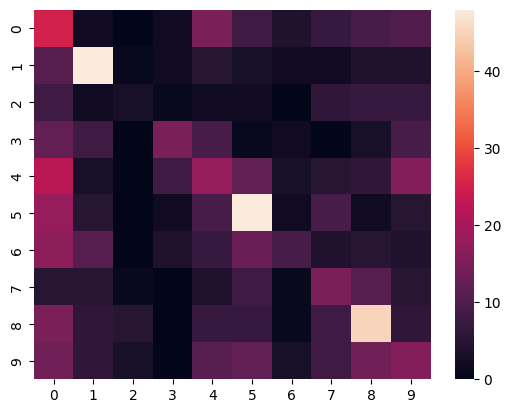

In [5]:
start = time.time()
svm = SVC(kernel='rbf', degree=3)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
end = time.time()
print("Time elapsed:", end - start)
print(np.unique(y_pred, return_counts=True))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred, labels=np.unique(y_test)))
print(classification_report(y_test, y_pred, zero_division=1))

### Random Forest - XGBoost

Time elapsed: 0.6377274990081787
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([137,  74,  14,  42,  88, 122,  39,  51, 110,  93]))
Accuracy: 0.41948051948051945
              precision    recall  f1-score   support

           0       0.28      0.46      0.35        82
           1       0.66      0.60      0.63        82
           2       0.50      0.18      0.27        38
           3       0.38      0.27      0.32        59
           4       0.32      0.30      0.31        93
           5       0.39      0.48      0.43       100
           6       0.69      0.36      0.48        74
           7       0.39      0.36      0.38        55
           8       0.55      0.61      0.58       100
           9       0.31      0.33      0.32        87

    accuracy                           0.42       770
   macro avg       0.45      0.40      0.41       770
weighted avg       0.45      0.42      0.42       770



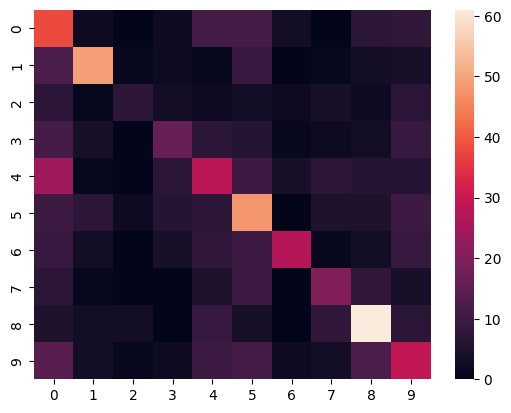

In [6]:
start = time.time()
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
end = time.time()
print("Time elapsed:", end - start)
print(np.unique(y_pred, return_counts=True))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# Model Precision: what percentage of positive tuples are labeled as such?

sns.heatmap(confusion_matrix(y_test, y_pred, labels=np.unique(y_test)))
print(classification_report(y_test, y_pred, zero_division=1))

### Simple MLP

In [7]:
learning_rate = 3e-2
batch_size = 256
epochs = 1000
n_classes = len(np.unique(y))

In [8]:
class BrainTumorDataset(Dataset):
    def __init__(self, data, data_label):
        self.data = data
        self.data_label = data_label

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_i = self.data[idx]
        data_label_i = self.data_label[idx]
        
        return data_i, data_label_i

In [9]:
class SimpleMLP(torch.nn.Module):

    def __init__(self, n_class):
        super(SimpleMLP, self).__init__()
        self.mlp = torch.nn.Sequential(torch.nn.Linear(64, 128),
                                       torch.nn.ReLU(),
                                       torch.nn.Linear(128, 256),
                                       torch.nn.ReLU(),
                                       torch.nn.Linear(256, 128),
                                       torch.nn.ReLU(),
                                       torch.nn.Linear(128, 64),
                                       torch.nn.ReLU(),
                                       torch.nn.Linear(64, 32),
                                       torch.nn.ReLU(),
                                       torch.nn.Linear(32, 16),
                                       torch.nn.ReLU(),
                                       torch.nn.Linear(16, n_class),)
                                       #torch.nn.Softmax(dim=1))

    def forward(self, x):
        x = self.mlp(x)
        return x

model = SimpleMLP(n_classes).type(torch.float64)

In [10]:
train_dataset = BrainTumorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = BrainTumorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

#val_dataset = BrainTumorDataset(val_image_dict, data_path, transform=transforms.ToTensor())
#val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [11]:
loss_fn = nn.CrossEntropyLoss()
#params = [p for p in vgg19.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

------------ Epoch: 0 ------------
Epoch: 0 Training loss: 0.454232
Time elapsed: 0.5495669841766357
------------ Epoch: 1 ------------
Epoch: 1 Training loss: 0.452976
Time elapsed: 0.015128612518310547
------------ Epoch: 2 ------------
Epoch: 2 Training loss: 0.449313
Time elapsed: 0.01457977294921875
------------ Epoch: 3 ------------
Epoch: 3 Training loss: 0.447577
Time elapsed: 0.014524459838867188
------------ Epoch: 4 ------------
Epoch: 4 Training loss: 0.444266
Time elapsed: 0.014726877212524414
------------ Epoch: 5 ------------
Epoch: 5 Training loss: 0.445758
Time elapsed: 0.014699220657348633
------------ Epoch: 6 ------------
Epoch: 6 Training loss: 0.449190
Time elapsed: 0.015001773834228516
------------ Epoch: 7 ------------
Epoch: 7 Training loss: 0.448308
Time elapsed: 0.015712976455688477
------------ Epoch: 8 ------------
Epoch: 8 Training loss: 0.443375
Time elapsed: 0.014836549758911133
------------ Epoch: 9 ------------
Epoch: 9 Training loss: 0.444910
Time ela

Text(0.5, 0, 'Epoch')

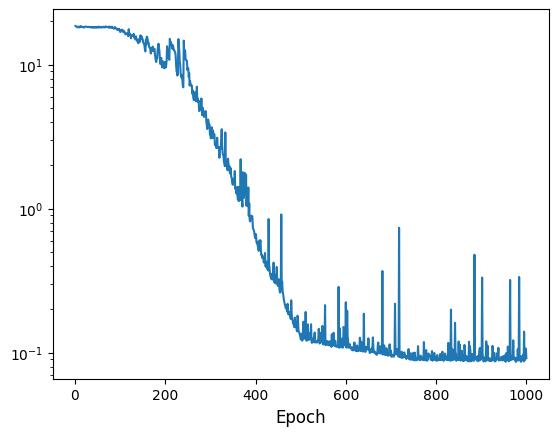

In [12]:
model.to(device)
all_loss = []
all_valid_loss = []
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=250, gamma=0.1)
for epoch in range(epochs):
    size = len(train_dataloader.dataset)
    print("------------ Epoch:", epoch, "------------")
    training_loss = 0
    valid_loss = 0
    start = time.time()
    for batch, (train_X, train_y) in enumerate(train_dataloader):
        # Compute prediction and loss
        pred = model(train_X.to(device))
        #print(torch.sum(pred[0]))
        loss = loss_fn(pred, train_y.to(device))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss, current = loss.item(), (batch + 1) * len(X)
        #print(loss)
        training_loss += loss
    
    scheduler.step()
    print("Epoch:", epoch,f"Training loss: {training_loss/41:>7f}")
    end = time.time()
    print("Time elapsed:", end - start)
    all_loss.append(training_loss)
    all_valid_loss.append(valid_loss)

fig = plt.figure()
plt.plot(range(1, epochs+1), all_loss)
plt.yscale("log")
plt.xlabel('Epoch', fontsize=12)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([ 92,  70,  68,  51, 117,  90,  45, 108,  60,  69]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([ 82,  82,  38,  59,  93, 100,  74,  55, 100,  87]))
              precision    recall  f1-score   support

           0       0.20      0.22      0.21        82
           1       0.57      0.49      0.53        82
           2       0.18      0.32      0.23        38
           3       0.29      0.25      0.27        59
           4       0.15      0.18      0.16        93
           5       0.44      0.40      0.42       100
           6       0.44      0.27      0.34        74
           7       0.18      0.35      0.23        55
           8       0.47      0.28      0.35       100
           9       0.25      0.20      0.22        87

    accuracy                           0.29       770
   macro avg       0.32      0.30      0.30       770
weighted avg       0.33      0.29      0.30       770



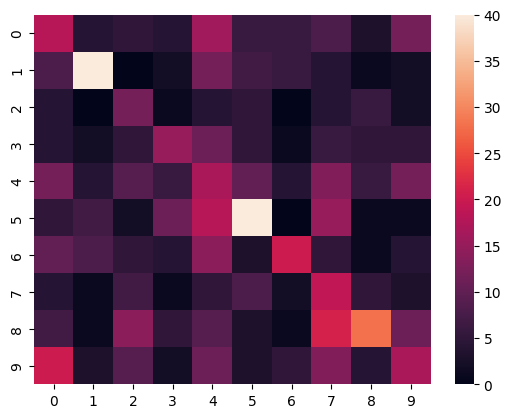

In [13]:
model.to('cpu')
predictions, true_labels = [], []
for batch, (test_X, test_y) in enumerate(test_dataloader):
    # Compute prediction and loss
    pred = torch.argmax(model(test_X), dim=1)
    #print(pred)
    predictions += pred.tolist()
    true_labels += test_y.tolist()

print(np.unique(predictions, return_counts=True))
print(np.unique(true_labels, return_counts=True))
sns.heatmap(confusion_matrix(true_labels, predictions, labels=range(0, n_classes)))
print(classification_report(true_labels, predictions, zero_division=1))